In [123]:
import pandas as pd

In [124]:
# data from https://doi.org/10.5281/zenodo.2562658
df = pd.read_csv("./district-heating-network-data-flensburg-2014-2016.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%d/%m/%y %H:%M")
# select 2014 as sample year
df = df.loc[df["Datetime"].dt.year == 2014].copy()
df

,Datetime,Feed flow temperature in °C,Average return flow temperature in °C,Overall heat load in MW
0,2014-01-01 00:00:00,94.0,50,167.59
1,2014-01-01 01:00:00,94.0,50,168.49
2,2014-01-01 02:00:00,94.0,50,172.58
3,2014-01-01 03:00:00,94.0,50,173.58
4,2014-01-01 04:00:00,96.0,50,185.57
...,...,...,...,...
8755,2014-12-31 19:00:00,95.0,50,209.00
8756,2014-12-31 20:00:00,96.0,50,207.00
8757,2014-12-31 21:00:00,98.0,50,208.00
8758,2014-12-31 22:00:00,98.0,50,198.00


In [125]:
duration_curve = df.sort_values(by="Overall heat load in MW", ascending=False)

In [126]:
duration_curve

,Datetime,Feed flow temperature in °C,Average return flow temperature in °C,Overall heat load in MW
609,2014-01-26 09:00:00,121.0,50,365.0
585,2014-01-25 09:00:00,119.0,50,363.0
610,2014-01-26 10:00:00,120.0,50,359.0
633,2014-01-27 09:00:00,117.0,50,358.0
632,2014-01-27 08:00:00,117.0,50,356.0
...,...,...,...,...
5020,2014-07-29 04:00:00,78.0,50,31.0
4986,2014-07-27 18:00:00,80.0,50,30.0
4987,2014-07-27 19:00:00,80.0,50,30.0
4988,2014-07-27 20:00:00,79.0,50,30.0


In [127]:
from matplotlib import pyplot as plt

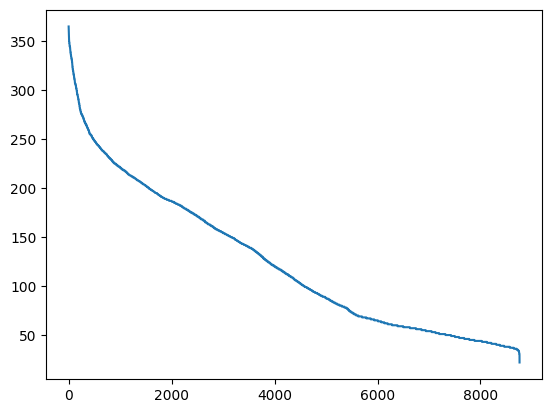

In [128]:
fix, ax = plt.subplots(1)

ax.plot(range(8760), duration_curve["Overall heat load in MW"])
# ax.plot(range(8760), df["Overall heat load in MW"])

In [129]:
heat_pump_nominal_load = 200
heat_pump_minimal_load = 120
heat_pump_operation = duration_curve["Overall heat load in MW"].copy()
heat_pump_operation.loc[heat_pump_operation > heat_pump_nominal_load] = heat_pump_nominal_load
heat_pump_operation.loc[heat_pump_operation < heat_pump_minimal_load] = 0

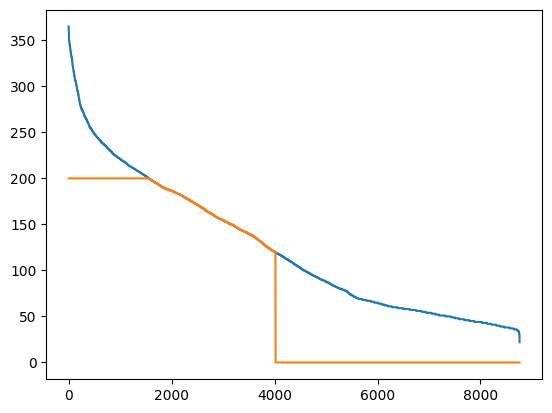

In [130]:
fix, ax = plt.subplots(1)

ax.plot(range(8760), duration_curve["Overall heat load in MW"])
ax.plot(range(8760), heat_pump_operation)

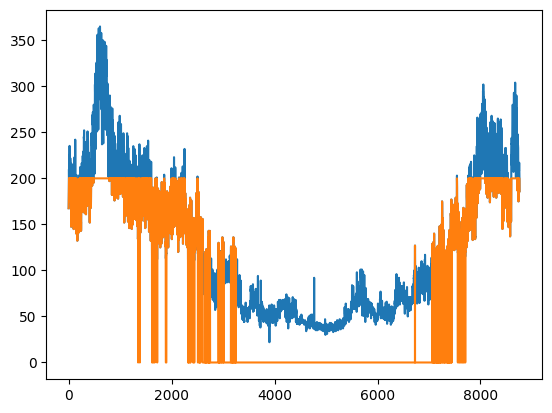

In [131]:
fix, ax = plt.subplots(1)

ax.plot(range(8760), df["Overall heat load in MW"])
ax.plot(range(8760), heat_pump_operation.sort_index())

In [132]:
df_daily = df.groupby(by=df["Datetime"].dt.dayofyear).agg(
    {
        "Datetime": "first",
        "Feed flow temperature in °C": "mean",
        "Average return flow temperature in °C": "mean",
        "Overall heat load in MW": "mean"
    }
)

In [133]:
duration_curve_daily = df_daily.sort_values(by="Overall heat load in MW", ascending=False)
heat_pump_nominal_load = 200
heat_pump_minimal_load = 120
heat_pump_operation = duration_curve_daily["Overall heat load in MW"].copy()
heat_pump_operation.loc[heat_pump_operation > heat_pump_nominal_load] = heat_pump_nominal_load
heat_pump_operation.loc[heat_pump_operation < heat_pump_minimal_load] = 0

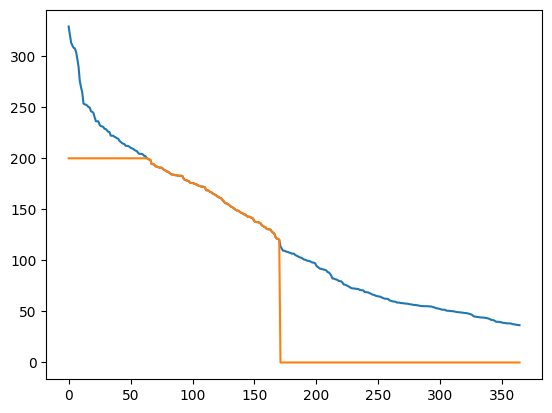

In [134]:
plt.plot(range(365), duration_curve_daily["Overall heat load in MW"])
plt.plot(range(365), heat_pump_operation)

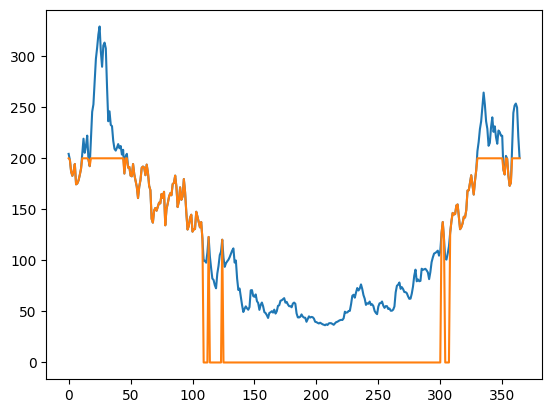

In [135]:
plt.plot(range(365), df_daily["Overall heat load in MW"])
plt.plot(range(365), heat_pump_operation.sort_index())

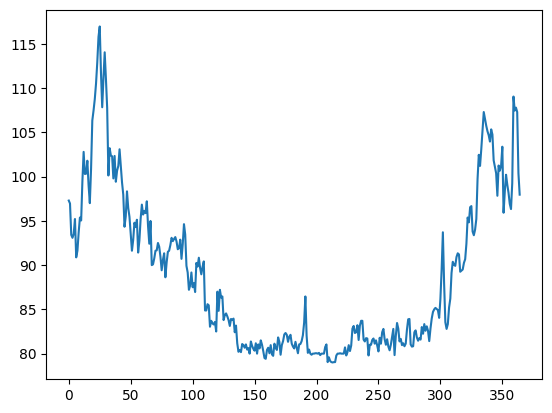

In [136]:
plt.plot(range(365), df_daily["Feed flow temperature in °C"])